<a href="https://colab.research.google.com/github/mareros22/QuantumComputerSimulator/blob/main/QuantumSimulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulator Code

## Imports

In [ ]:
import numpy as np
import math, random, cmath
import matplotlib
from matplotlib import pyplot as plt, patches

## Visualization

In [ ]:
def viz2(qubit, n_states):
  # calculate amplitude and phase
  # calculate the amplitude and phase of the states
  prob_qubit = np.absolute(qubit)
  phase_qubit = np.angle(qubit)
  # viz par
  rows = int(math.ceil(n_states / 32.0))
  cols = min(n_states, 32)
  fig, axs = plt.subplots(rows, cols)
  if rows == 1:
    for col in range(cols):
        # amplitude area
        circleExt = matplotlib.patches.Circle((0.5, 0.5), 0.5, color='gray',alpha=0.1)
        circleInt = matplotlib.patches.Circle((0.5, 0.5), prob_qubit[col]/2, color='b',alpha=0.3)
        axs[col].add_patch(circleExt)
        axs[col].add_patch(circleInt)
        axs[col].set_aspect('equal')
        state_number = "|" + str(col) + ">"
        axs[col].set_title(state_number)
        xl = [0.5, 0.5 + 0.5*prob_qubit[col]*math.cos(phase_qubit[col] + np.pi/2)]
        yl = [0.5, 0.5 + 0.5*prob_qubit[col]*math.sin(phase_qubit[col] + np.pi/2)]
        axs[col].plot(xl,yl,'r')
        axs[col].axis('off')
  else:
    for col in range(cols):
      for row in range(rows):
        # amplitude area
        circleExt = matplotlib.patches.Circle((0.5, 0.5), 0.5, color='gray',alpha=0.1)
        circleInt = matplotlib.patches.Circle((0.5, 0.5), prob_qubit[col]/2, color='b',alpha=0.3)
        axs[row][col].add_patch(circleExt)
        axs[row][col].add_patch(circleInt)
        axs[row][col].set_aspect('equal')
        state_number = "|" + str(col) + ">"
        axs[row][col].set_title(state_number)
        xl = [0.5, 0.5 + 0.5*prob_qubit[col + 8*(row)]*math.cos(phase_qubit[col + 8*(row)] + np.pi/2)]
        yl = [0.5, 0.5 + 0.5*prob_qubit[col + 8*(row)]*math.sin(phase_qubit[col + 8*(row)] + np.pi/2)]
        axs[row][col].plot(xl,yl,'r')
        axs[row][col].axis('off')
  plt.show()

## Quantum State Class

In [ ]:
class quantum_state:
  def __init__(self, size=1, in_state=0, name=""):
    self.qubits = size
    self.state = np.zeros(2**size, dtype=np.complex128)
    self.state[in_state] = 1
    self.name = name

  def __str__(self):
    return self.name + ": " + str(self.state) + "( size: " + str(self.qubits) + " qubits)"

  ### Gates
  def h(self):
    s = self.state.dot(hadamard_matrix(self.qubits))
    self.state = round_arr(s, 15)

  def h(self, index=None):
    if(index == None):
      s = self.state.dot(hadamard_matrix(self.qubits))
      self.state = round_arr(s, 15)
      return
    k = 0
    for i in range(int((2**self.qubits)/(2**(index+1)))):
      for j in range(2**index):
        vec = np.zeros(2, dtype=np.complex128)
        vec[0] = self.state[k+j]
        vec[1] = self.state[k + j+2**index]
        vh = vec.dot(hadamard_matrix(1))
        self.state[k+j] = vh[0]
        self.state[k+j + 2**index] = vh[1]
      k += 2**index + 1 + j

  def x(self):
    self.state = self.state.dot(not_matrix(self.qubits))

  def x(self, index):
    k = 0
    for i in range(int((2**self.qubits)/(2**(index+1)))):
      for j in range(2**index):
        vec = np.zeros(2, dtype=np.complex128)
        vec[0] = self.state[k+j]
        vec[1] = self.state[k + j+2**index]
        vh = vec.dot(not_matrix(1))
        self.state[k+j] = vh[0]
        self.state[k+j + 2**index] = vh[1]
      k += 2**index + j + 1

  def read(self, index1=None, index2=None):
    if index1==None and index2 == None:
      prob = square_all(self.state)
      rp = random.random()
      n = 0
      while rp > 0:
        rp = rp - prob[n]
        n = n + 1
      self.state = np.zeros(len(self.state), dtype=np.complex128)
      self.state[n-1] = 1
      return n-1
    elif index2 == None: # reading value at one index
      prob = square_all(self.state)
      rp = random.random()
      k = 0
      pairs = []
      for i in range(int((2**self.qubits)/(2**(index1+1)))):
        for j in range(2**index1):
          pairs.append((k+j, k+j+2**index1))
        k += 2**index1 + 1 + j
      p0 = 0
      p1 = 0
      numpairs = len(pairs)
      for p in pairs:
        p0 += prob[p[0]]
        p1 += prob[p[1]]
      if(rp < p0): # read value is 0
        for l in range (numpairs):
          prob0 = prob[pairs[l][0]]
          self.state[pairs[l][0]] = np.sqrt(prob0 / p0)
          self.state[pairs[l][1]] = 0
        return 0
      else: # read value is 1
        for l in range (numpairs):
          prob1 = prob[pairs[l][1]]
          self.state[pairs[l][1]] = np.sqrt(prob1 / p1)
          self.state[pairs[l][0]] = 0
        return 1
    else: # reading value over range of indices
      binstr = ""
      for i in range(index2, index1 - 1, -1):
        digit = self.read(i)
        binstr = binstr + str(digit)
      return(int(binstr, 2))


  def phase(self, phi):
    self.state= self.state.dot(phase_matrix(phi, self.qubits))

  def phase(self, phi, index):
    k = 0
    for i in range(int((2**self.qubits)/(2**(index+1)))):
      for j in range(2**index):
        vec = np.zeros(2, dtype=np.complex128)
        vec[0] = self.state[k+j]
        vec[1] = self.state[k + j+2**index]
        vh = vec.dot(phase_matrix(phi, 1))
        self.state[k+j] = vh[0]
        self.state[k+j + 2**index] = vh[1]
      k += 2**index + 1 + j

  def cphase(self, index0, index1, phi):
    #initially assuming 2 qubit parameters and 2-3 in state but need to come back and add
    if(self.qubits == 2):
      self.state = self.state.dot(cphase_matrix(phi))
    else:
      c = index0 + index1
      # print("c, ", c)
      if c == 1:
        self.state[0:4] = self.state[0:4].dot(cphase_matrix(phi))
        self.state[4:8] = self.state[4:8].dot(cphase_matrix(phi))
      elif c == 2:
        #print("--------CASE: ROTATE 0,2 --------")
        #print(self.state)
        v1 = np.array([self.state[0], self.state[1], self.state[4], self.state[5]], dtype=np.complex128)
        #print("v1: ", v1)
        v1 = v1.dot(cphase_matrix(phi))
        self.state[0:2] = v1[0:2]
        self.state[4:6] = v1[2:4]
        v2 = np.array([self.state[2], self.state[3], self.state[6], self.state[7]], dtype=np.complex128)
        #print("v2: ", v2)
        v2 = v2.dot(cphase_matrix(phi))
        self.state[2:4] = v2[0:2]
        self.state[6:8] = v2[2:4]
        #print("final: ", self.state)
      else:
        v1 = np.array([self.state[0], self.state[2], self.state[4], self.state[6]], dtype=np.complex128)
        v1 = v1.dot(cphase_matrix(phi))
        v2 = np.array([self.state[1], self.state[3], self.state[5], self.state[7]], dtype=np.complex128)
        v2 = v2.dot(cphase_matrix(phi))
        for i in range(4):
          self.state[2*i] = v1[i]
          self.state[2*i +1] = v2[i]

  def rotx(self, theta, index):
    k = 0

    rx_matrix = np.array([
        [np.cos(theta / 2), -1j * np.sin(theta / 2)],
        [-1j * np.sin(theta / 2), np.cos(theta / 2)]
    ], dtype=np.complex128)

    for i in range(int((2**self.qubits) / (2**(index + 1)))):
        for j in range(2**index):
            vec = np.zeros(2, dtype=np.complex128)
            vec[0] = self.state[k + j]
            vec[1] = self.state[k + j + 2**index]

            # Apply the X rotation
            vh = rx_matrix.dot(vec)
            self.state[k + j] = vh[0]
            self.state[k + j + 2**index] = vh[1]

        k += 2**index + 1 + j

  def roty(self, theta, index):
    k = 0
    # Y rotation matrix for a single qubit
    ry_matrix = np.array([
        [np.cos(theta / 2), -np.sin(theta / 2)],
        [np.sin(theta / 2), np.cos(theta / 2)]
    ], dtype=np.complex128)

    # Iterate over blocks of the quantum state that involve the target qubit
    for i in range(int((2**self.qubits) / (2**(index + 1)))):
        for j in range(2**index):
            vec = np.zeros(2, dtype=np.complex128)
            vec[0] = self.state[k + j]
            vec[1] = self.state[k + j + 2**index]

            # Apply the Y rotation
            vh = ry_matrix.dot(vec)
            self.state[k + j] = vh[0]
            self.state[k + j + 2**index] = vh[1]

        k += 2**index + 1 + j

  def cnot(self, index, control):
    arg = [control]
    self.ccnot(index, arg)

  def ccnot(self, index, control):
    k = 0
    pairs = []
    for i in range(int((2**self.qubits)/(2**(index+1)))):
      for j in range(2**index):
        pairs.append((k+j, k+j+2**index))
      k += 2**index + 1 + j
    for l in control:
      for m in range (len(pairs)-1, -1, -1):
        p = pairs[m]
        b0 = bin(p[0])[2:].zfill(self.qubits)
        b1 = bin(p[1])[2:].zfill(self.qubits)
        if b0[len(b0)-1-l] == '0' or b1[len(b1)-1-l] == '0' :
          pairs.pop(m)
    for n in pairs:
      v = np.zeros(2, dtype=np.complex128)
      v[0] = self.state[n[0]]
      v[1] = self.state[n[1]]
      v = v.dot(not_matrix())
      self.state[n[0]] = v[0]
      self.state[n[1]] = v[1]

  def combine_state(q1, q2):
    tp = quantum_state(size=q1.qubits+q2.qubits)
    tp.state = np.kron(q1.state, q2.state)
    return tp

## Gates

In [ ]:
def not_matrix(q=1):
  x = np.array([[0, 1], [1, 0]])
  y = x
  for a in range (q-1):
    y = np.kron(x, y)
  # print(y)
  return y

def hadamard_matrix(q=1):
  sq = 1/math.sqrt(2)
  x = np.array([[sq, sq],[sq, -sq]], dtype=np.float64)
  y = x
  for a in range (q-1):
    y = np.kron(x, y)
  return y

def cnot_matrix(target=1):
  if target == 0:
    return np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0, 0, 0, 1],[0, 0, 1, 0]])
  return np.array([[1, 0, 0, 0],[0, 0, 0, 1],[0,0,1,0],[0,1,0,0]])

def phase_matrix(phi, q=1):
  turn = mult = cmath.exp(complex(0.0, 1.0) * phi)
  p = np.array([[1, 0], [0, turn]])
  p[1,1] = turn
  # print("p: ", p)
  return p

### auxillary
def round_arr(a, l):
  for n in range(len(a)):
    a[n] = round(a[n].real, l) + a[n].imag
  return a

def square_all(a):
  for n in range(len(a)):
    sqr = pow(a[n].real, 2) + pow(a[n].imag, 2)
    a[n] = sqr
  return a

def cphase_matrix(phi):
  mult = cmath.exp(complex(0.0, 1.0) * phi)
  return np.array([[1, 0, 0, 0],[0, 1, 0, 0],[0,0,1,0],[0,0,0,mult]], dtype=np.complex128)

def swap_matrix():
  return np.array([[1, 0, 0, 0],[0, 0, 1, 0],[0,1,0,0],[0,0,0,1]], dtype=np.complex128)

## Simulation Tools

In [ ]:
def simulate(circuit, out_size=1, runs=500, as_decimal=False, *args):
  a = []
  for b in args:
    a.append(b)
  nums = dict()
  for i in range(2**out_size):
    nums[i] = 0
  print(a)
  for j in range(runs):
    c = circuit(registers=a)
    if (c == None):
      raise RuntimeError("circuit has no measurements taken")
      return -1
    nums[c] += 1

  # If as_decimal is True, convert frequencies to decimals
  if as_decimal:
      for key in nums:
          nums[key] = nums[key] / runs

  return nums

# Demo Code

## Circuits

In [ ]:
def bell_state(s0=None, s1=None, **kwargs):
  if(s0 == None):
    s0 = kwargs['registers'][0]
  if(s1 == None):
    s1 = kwargs['registers'][1]
  reg = quantum_state.combine_state(s0, s1)
  print("before applying bell circuit")
  viz2(reg.state, 4)
  reg.h(0)
  reg.cnot()
  print("after applying bell circuit")
  viz2(reg.state, 4)

def qft(reg=None, **kwargs):
  if(reg == None):
    reg = kwargs['registers'][0]
  print("before applying qft")
  viz2(reg.state, 8)
  #dft 1
  reg.h(2)
  reg.cphase(2, 1, -np.pi/2)
  reg.cphase(2, 0, -np.pi/4)
  #dft 2
  reg.h(1)
  reg.cphase(1, 0, -np.pi/2)
  #dft 3
  reg.h(0)
  #swap
  reg.cnot(2,0)
  reg.cnot(0,2)
  reg.cnot(2,0)
  print("after applying qft")
  viz2(reg.state, 8)

def prep_qft(reg=None, **kwargs):
  if(reg == None):
    reg = kwargs['registers'][0]
  reg.h()
  reg.phase(np.pi/4, 0)
  reg.phase(np.pi/2, 1)
  reg.phase(np.pi, 2)

def inv_qft(reg=None, **kwargs):
  if(reg == None):
    reg = kwargs['registers'][0]
  print("before applying inv_qft")
  viz2(reg.state, 8)
  # swap
  reg.cnot(2,0)
  reg.cnot(0,2)
  reg.cnot(2,0)
  # reverse dft 1
  reg.h(0)
  reg.cphase(0, 1, np.pi/2)
  reg.cphase(0, 2, np.pi/4)
  # reverse dft 2
  reg.h(1)
  reg.cphase(1, 2, np.pi/2)
  # reverse dft 3
  reg.h(2)



def rng(reg=None, **kwargs):
  if reg == None :
    reg = kwargs['registers'][0]
  reg.h()
  return reg.read()

def walk(pos=None, coin=None, steps=30, **kwargs):
  if(pos == None):
    pos = kwargs['registers'][0]
  if(coin == None):
    coin = kwargs['registers'][1]
  cindex = pos.qubits
  reg = quantum_state.combine_state(pos, coin)
  reg.x(6)
  for i in range (steps):
    reg.h(cindex)
    reg.ccnot(6, [cindex, 5, 4, 3, 2, 1, 0])
    reg.ccnot(5, [cindex, 4, 3, 2, 1, 0])
    reg.ccnot(4, [cindex, 3, 2, 1, 0])
    reg.ccnot(3, [cindex, 2, 1, 0])
    reg.ccnot(2, [cindex, 1, 0])
    reg.ccnot(1, [cindex, 0])
    reg.cnot(0, cindex)
    reg.x(cindex)
    reg.cnot(0, cindex)
    reg.ccnot(1, [cindex, 0])
    reg.ccnot(2, [cindex, 1, 0])
    reg.ccnot(3, [cindex, 2, 1, 0])
    reg.ccnot(4, [cindex, 3, 2, 1, 0])
    reg.ccnot(5, [cindex, 4, 3, 2, 1, 0])
    reg.ccnot(6, [cindex, 5, 4, 3, 2, 1, 0])
    reg.x(cindex)
  ret = reg.read(0, 6)
  return ret

def add_subtract(reg = None, **kwargs):
  if reg == None:
    reg = kwargs['registers'][0]
  reg.h(2)
  print("before adding")
  viz2(reg.state, 16)
  reg.ccnot(3, [2, 1, 0])
  reg.ccnot(2, [1, 0])
  reg.cnot(1, 0)
  reg.x(0)
  print("after adding")
  viz2(reg.state, 16)
  reg.x(0)
  reg.cnot(1, 0)
  reg.ccnot(2, [1, 0])
  reg.ccnot(3, [2, 1, 0])
  print("after subtracting")
  viz2(reg.state, 16)




## Demonstration: Bell State

before applying bell circuit


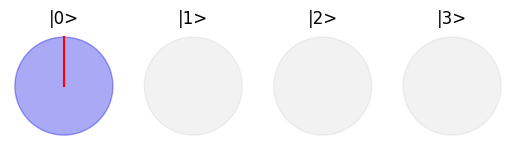

after applying bell circuit


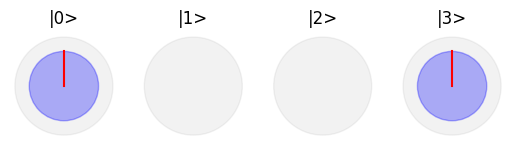

In [ ]:
s0 = quantum_state(1, 0, name="s0")
s1 = quantum_state(1, 0, name="s1")
bell_state(s0, s1)

## Demonstration: QFT

before applying qft


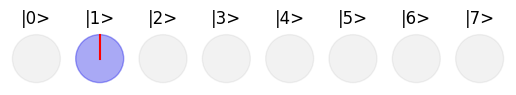

after applying qft


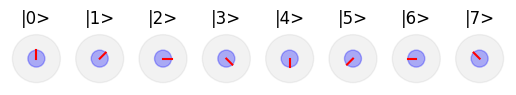

In [ ]:
s2 = quantum_state(3, 1, name="s2")
qft(s2)

### Attempting to Prepare State

before applying inv_qft


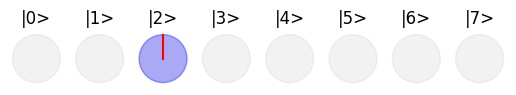

before applying qft


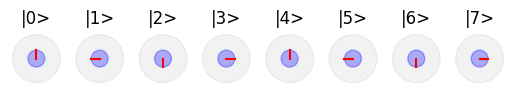

after applying qft


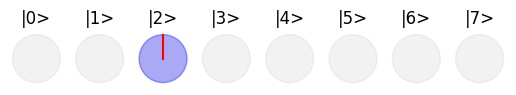

In [ ]:
s2 = quantum_state(3, 2, name="s2")
inv_qft(s2)
qft(s2)

## Demonstration: RNG

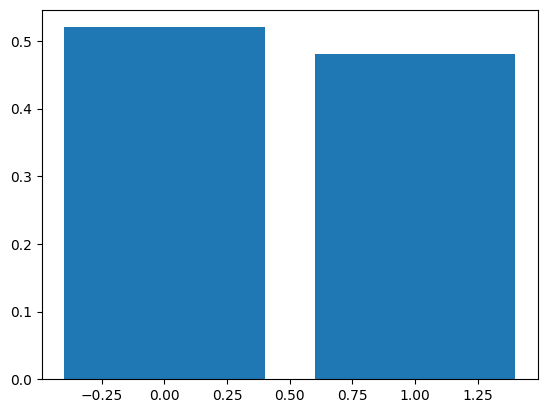

In [ ]:
s0 = quantum_state(1, 0, name="s0")
results = simulate(rng, 1, 500, True, s0)
plt.bar(results.keys(), results.values())
plt.show()

## Demonstration: Quantum Arithmetic

before adding


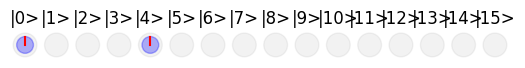

after adding


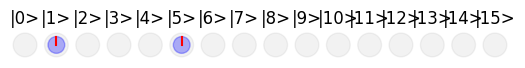

after subtracting


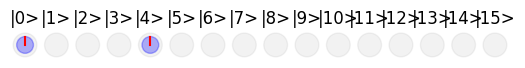

In [ ]:
s2 = quantum_state(4, 0, name="s2")
add_subtract(s2)

## Demonstration: Discrete Quantum Walk

[<__main__.quantum_state object at 0x79400c19acb0>, <__main__.quantum_state object at 0x79400c19a020>]


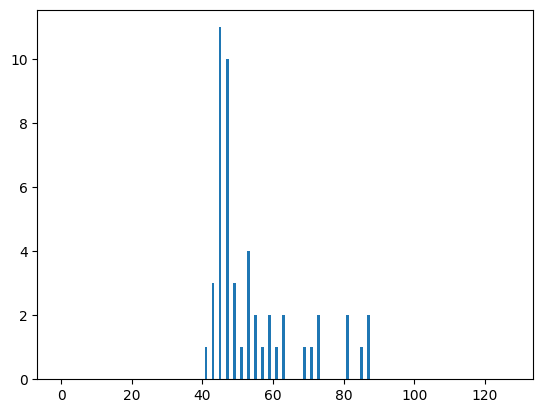

In [ ]:
s0 = quantum_state(7, 0, name="s0")
coin = quantum_state(1, 1, name="coin")
results = simulate(walk, 7, 50, False, s0, coin)
plt.bar(results.keys(), results.values())
plt.show()

# Gates Functionality Demonstration

## HAD

In [ ]:
s0 = quantum_state(1, 0, name="s0")
print("before applying the HAD gate")
viz2(s0.state, 2)
s0.h()
print("after applying the HAD gate")
viz2(s0.state, 2)

## NOT

In [ ]:
s0 = quantum_state(1, 0, name="s0")
print("before applying the NOT gate")
viz2(s0.state, 2)
s0.x(0)
print("after applying the NOT gate")
viz2(s0.state, 2)

## CNOT

Before applying the CNOT gate


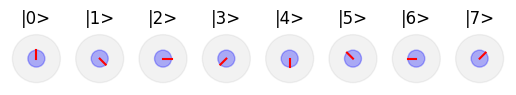

After applying the CNOT gate


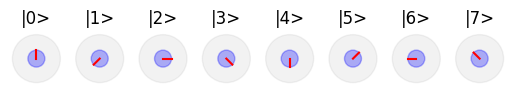

In [ ]:
s0 = quantum_state(3, 3, name="s0")
s0.h(0)
s0.h(1)
s0.h(2)
s0.phase(np.pi/4, 0)
s0.phase(np.pi/2, 1)
s0.phase(np.pi, 2)

print("Before applying the CNOT gate")
viz2(s0.state, 8)

s0.cnot(1, 0)

print("After applying the CNOT gate")
viz2(s0.state, 8)

##CCNOT

Before applying the CCNOT gate


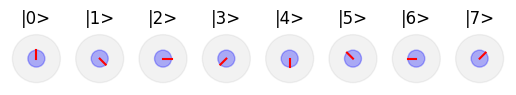

After applying the CCNOT gate


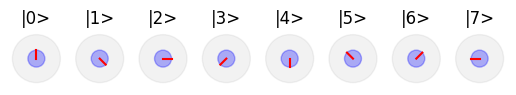

In [ ]:
s0 = quantum_state(3, 3, name="s0")
s0.h(0)
s0.h(1)
s0.h(2)
s0.phase(np.pi/4, 0)
s0.phase(np.pi/2, 1)
s0.phase(np.pi, 2)

print("Before applying the CCNOT gate")
viz2(s0.state, 8)

s0.ccnot(0, [1,2])

print("After applying the CCNOT gate")
viz2(s0.state, 8)

## Phase

In [ ]:
s0 = quantum_state(1, 0, name="s0")
s0.h()
print("before applying the phase (45) gate")
viz2(s0.state, 2)
s0.phase(np.pi/4, 0)
print("after applying the phase (45) gate")
viz2(s0.state, 2)

## CPhase

Before applying the CPhase (45) gate


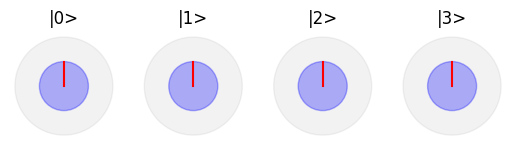

After applying the CPhase (45) gate


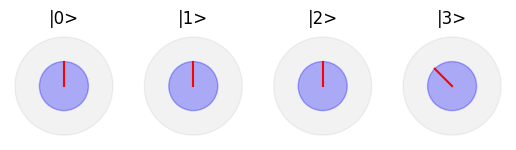

In [ ]:
s0 = quantum_state(2, 0, name="s0")
s0.h()

print("Before applying the CPhase (45) gate")
viz2(s0.state, 4)

s0.cphase(0, 1, np.pi/4)

print("After applying the CPhase (45) gate")
viz2(s0.state, 4)

## RotX

In [ ]:
s0 = quantum_state(1, 0, name="s0")
print("before applying the rotX (45) gate")
viz2(s0.state, 2)
s0.rotx(np.pi/4, 0)
print("after applying the rotX (45) gate")
viz2(s0.state, 2)

## RotY

In [ ]:
s0 = quantum_state(1, 0, name="s0")
print("before applying the rotY (45) gate")
viz2(s0.state, 2)
s0.roty(np.pi/4, 0)
print("after applying the rotY (45) gate")
viz2(s0.state, 2)

# Testing out reading

entire register


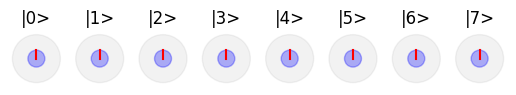

3


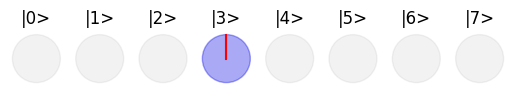

single index (1)


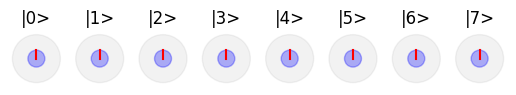

0


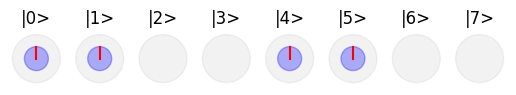

read range (0,1)


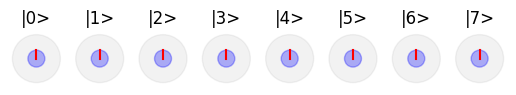

3


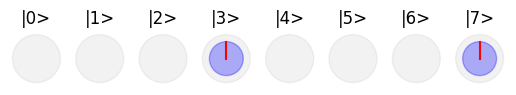

In [ ]:
print("entire register")
s2 = quantum_state(3, 0, name="s2")
s2.h()
viz2(s2.state, 8)
print(s2.read())
viz2(s2.state, 8)
print("single index (1)")
s0 = quantum_state(3, 0, name="s0")
s0.h()
viz2(s0.state, 8)
print(s0.read(1))
viz2(s0.state, 8)
print("read range (0,1)")
s1 = quantum_state(3, 0, name="s0")
s1.h()
viz2(s1.state, 8)
print(s1.read(0,1))
viz2(s1.state, 8)